# Data Science Fellowship program exam

**Machine Learning - Assignment 2: Natural disasters dataset**

By: Jules Kuehn

Due: 2020-12-03, 6pm Eastern

## Task 2: Feature generation and traditional ML model

Not implemented, but would be nice:
* Common functions moved to python module, to be imported into multiple notebooks.
* (Some code is duplicated here from the previous notebook.)

### Setup

In [21]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [81]:
# Suppress warnings for cleaner output
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import re
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from wordcloud import WordCloud

### Import data
Use Pandas to import the CSV to a Dataframe. For a larger dataset, I would use Spark for pre-processing steps.

In [14]:
train_df = pd.read_csv('../data/raw/train.csv')
disaster_tweets = train_df[train_df['target'] == 1]['text'].tolist()
non_disaster_tweets = train_df[train_df['target'] == 0]['text'].tolist()

### TF-IDF feature extraction

We will start with the CountVectorizer from the previous notebook, then apply TF-IDF processing.

Note that custom pre-processing was found to be unnecessary, so our pipeline begins with the CountVectorizer.

In [53]:
def create_vectorizer(
    non_disaster_tweets,
    disaster_tweets,
    initial_vocab='all',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    strip_accents='ascii',
    lowercase=True,
    ngram_range=(1, 1),
    ):
    """
    Create a CountVectorizer for use in a bag-of-words model.
    Takes a list of non-disaster tweets and a list of disaster tweets.
    Optionally removes some common or uncommon words.
    Returns a CountVectorizer with the limited vocabulary.
    """

    if initial_vocab == 'disaster':
        initial_vocab_tweets = disaster_tweets
    else:
        initial_vocab_tweets = non_disaster_tweets + disaster_tweets

    # Get vocabulary from tweets (optionally removing uncommon words)
    transformer = CountVectorizer(
        strip_accents=strip_accents,
        lowercase=lowercase,
        min_df=min_df,
        max_features=max_features,
        ngram_range=ngram_range,
    ).fit(initial_vocab_tweets)

    if remove_n_common_words > 0:
        final_vocabulary = transformer.vocabulary_.copy()
        # Get the most common words in the non-disaster tweets
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            min_df=min_df,
            ngram_range=ngram_range,
        ).fit(non_disaster_tweets)
        bow = transformer.transform(list(non_disaster_tweets) + list(disaster_tweets))
        word_freqs = dict(zip(
            transformer.get_feature_names_out(),
            np.asarray(bow.sum(axis=0))[0]
        ))
        common_words = sorted(
            word_freqs.items(), key=lambda x: x[1], reverse=True
        )[:remove_n_common_words]

        # Remove most common non-disaster words from disaster tweets vocabulary
        for word in common_words:
            final_vocabulary.pop(word[0], None)

        # Create the final vectorizer with the limited vocabulary
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            vocabulary=final_vocabulary.keys(),
            ngram_range=ngram_range,
        ).fit(disaster_tweets)
    
    return transformer



### Model training and evaluation

Note that I am not using the test data at this time. I am only using the training data while testing pre-processing hyperparameters.

(We will use the test data in the last task of this exam, to compare all models.)

This code is largely the same as in notebook 1_BoW, but with the TF-IDF transformer added and manual pre-processing steps removed.

In [78]:
def evaluate_preprocessing(
    train_df,
    strip_accents='ascii',
    lowercase=True,
    initial_vocab='all',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    verbose=False,
    return_artifacts=False,
    ngram_range=(1, 1),
    use_idf=True,
    norm='l2',
    smooth_idf=True,
    sublinear_tf=False,
    clf=LogisticRegression(),
    tfidf=True,
):

    non_disaster_tweets = train_df[train_df['target'] == 0]['text'].tolist()
    disaster_tweets = train_df[train_df['target'] == 1]['text'].tolist()

    # Create vectorizer with limited vocabulary
    vectorizer = create_vectorizer(
        non_disaster_tweets,
        disaster_tweets,
        initial_vocab=initial_vocab,
        remove_n_common_words=remove_n_common_words,
        min_df=min_df,
        max_features=max_features,
        strip_accents=strip_accents,
        lowercase=lowercase,
        ngram_range=ngram_range,
    )
    
    # Fit TF-IDF transformer
    all_tweets = train_df['text']
    tfidf_transformer = TfidfTransformer(
        use_idf=use_idf,
        norm=norm,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf,
    ).fit(vectorizer.transform(all_tweets))

    # Create a pipeline to vectorize and apply TF-IDF
    # Classifier is passed as an argument for comparison
    pipeline = Pipeline([
        ('vect', vectorizer),
        ('tfidf', tfidf_transformer if tfidf else None),
        ("clf", clf),
    ])


    # Split the training data into training and validation sets
    X_train = all_tweets
    y_train = train_df['target']

    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
    )

    pipeline.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = pipeline.predict(X_val)

    if verbose:
        # Display results on validation set
        print(classification_report(y_val, preds_val))
        ConfusionMatrixDisplay.from_estimator(pipeline, X_val, y_val, cmap='Blues', normalize='true')
    
    if return_artifacts:
        return pipeline, X_train, X_val, y_train, y_val

    # Return f1 macro average score
    return f1_score(y_val, preds_val, average='macro')


### Selecting a model
TF-IDF will not necessarily improve performance. Let's evaluate its effects with a variety of SkLearn models.


c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklear

Best result:
 ({'clf': SVC(max_iter=2000, random_state=42), 'tfidf': False, 'ngram_range': (1, 1)}, 0.789233228475146)


c:\Users\JKUEHN\Anaconda3\envs\ec6_exam\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



0.789233228475146

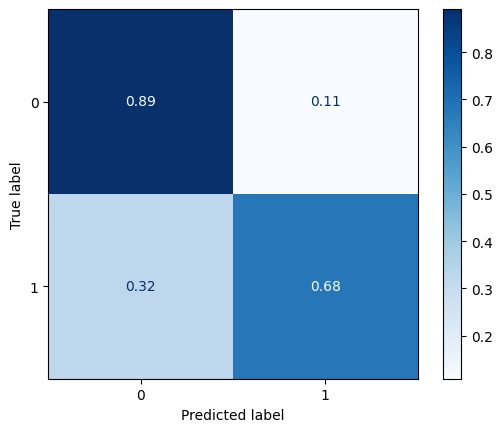

In [79]:
def grid_parameters(parameters):
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

parameters = {
    'clf': [
        LogisticRegression(max_iter=2000, random_state=42),
        RandomForestClassifier(max_depth=250, random_state=42), # Informed guess at max_depth
        SGDClassifier(max_iter=2000, random_state=42),
        SVC(max_iter=2000, random_state=42),
        LinearSVC(max_iter=2000, random_state=42),
        MultinomialNB(),
    ],
    'tfidf': [True, False],
    'ngram_range': [(1, 1), (1, 2), (1, 3)]
}

results = []

for settings in grid_parameters(parameters):
    f1_macro = evaluate_preprocessing(train_df, **settings, verbose=False)
    results.append((settings, f1_macro))

best_result = max(results, key=lambda x: x[1])
print("Best result:\n", best_result)

evaluate_preprocessing(train_df, **best_result[0], verbose=True)

In [80]:
print('Top 3 models:')
sorted(results, key=lambda x: x[1], reverse=True)[:3]

Top 3 models:


[({'clf': SVC(max_iter=2000, random_state=42),
   'tfidf': False,
   'ngram_range': (1, 1)},
  0.789233228475146),
 ({'clf': SVC(max_iter=2000, random_state=42),
   'tfidf': True,
   'ngram_range': (1, 1)},
  0.7844887644132201),
 ({'clf': MultinomialNB(), 'tfidf': True, 'ngram_range': (1, 3)},
  0.7812398369577)]

### Summary of results

We evaluated the effect of additional feature engineering:
* TF-IDF weighting
* Bigrams
* Trigrams

And several different ML models:
* Logistic Regression
* Random Forest
* SGD
* SVC
* Linear SVC
* Multinomial Naive Bayes

The best results came from the model we already obtained in the previous notebook:

**A simple bag of words model with Logistic Regression.**

### Explaining the model

*(Copied from previous notebook with modifications to use the Pipeline)*

An advantage of the bag of words + logistic regression model is its simplicity.

We can simply look up the model coefficients to determine feature importance:
* Which words contribute to a classification of "disaster" (1) or "non-disaster" (0)?

There is no need to scale the coefficients here since all the features are from the BoW.

In [63]:
pipeline, X_train, X_val, y_train, y_val = evaluate_preprocessing(
    train_df, **best_result[0], return_artifacts=True
)

model_coefficients = pd.DataFrame(
   pipeline['clf'].coef_.T,
   columns=['Coefficients'], index=pipeline['vect'].get_feature_names_out()
)

sorted_words = model_coefficients.sort_values('Coefficients', ascending=False)
print('The following words have the highest positive coefficients (disaster):')
print(sorted_words.head(10).to_string())

print('\nThe following words have the most negative coefficients (non-disaster):')
print(sorted_words.tail(10)[::-1].to_string())

The following words have the highest positive coefficients (disaster):
            Coefficients
hiroshima       2.445416
wildfire        2.359061
earthquake      2.220706
derailment      2.186881
fires           2.132240
tornado         1.992465
riots           1.907593
suicide         1.897605
massacre        1.870264
floods          1.869637

The following words have the most negative coefficients (non-disaster):
        Coefficients
full       -1.564929
better     -1.506215
blight     -1.411568
ebay       -1.404008
bags       -1.243934
cake       -1.237400
upon       -1.234887
show       -1.211611
art        -1.197938
likely     -1.184574


#### Explaining a single prediction

In [68]:
def predict_and_explain(tweet, pipeline, settings):
    """Predict the class of a tweet and explain the prediction."""
    bow = pipeline['vect'].transform([tweet])
    prediction = pipeline['clf'].predict(bow)[0]
    word_importance = []
    
    # Get words from bow
    words = pipeline['vect'].get_feature_names_out()

    # Get model coefficients
    coefficients = pipeline['clf'].coef_[0]

    # Get coefficients for words in the tweet
    for i, word in enumerate(words):
        if bow[0, i] > 0:
            word_importance.append((word, coefficients[i]))

    word_importance = sorted(word_importance, key=lambda x: x[1], reverse=True)

    print(f'Prediction: {"disaster" if prediction == 1 else "non-disaster"}\n')
    for word, coefficient in word_importance:
        print(f'{word}: {coefficient:.2f}')
    
    return prediction, word_importance


In [69]:
tweet = train_df['text'].sample(1).values[0]
print(tweet, '\n')

prediction, word_importance = predict_and_explain(tweet, pipeline, best_result[0])


So apparently there were bush fires near where I live over the weekend that I was totally oblivious to... 

Prediction: disaster

fires: 2.13
near: 0.95
were: 0.81
over: 0.71
bush: 0.49
was: 0.35
apparently: 0.28
that: 0.07
totally: -0.01
there: -0.01
live: -0.02
where: -0.37
weekend: -0.41
so: -0.49
